In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay, precision_score, recall_score
import seaborn as sns

import graphviz
import plotly.express as px
import plotly.graph_objects as go
from dtreeviz.trees import dtreeviz
from dtreeviz.models.sklearn_decision_trees import ShadowSKDTree

from IPython.display import Image

FIG_WIDTH = 1280
FIG_HEIGHT = 720

random_state = 13

def plot_figure(fig, static=True):
    fig.update_layout(width=FIG_WIDTH, height=FIG_HEIGHT)
    if static:
        img_bytes = fig.to_image(format="png")
        return Image(img_bytes)
    else:
        fig.show()

# Loading train and test data

In [8]:
train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/test.csv")

X_train = train_df.drop("Machine failure", axis="columns")
X_test = test_df.drop("Machine failure", axis="columns")

features = X_train.columns.to_list()
target = "Machine failure"

y_train = train_df[target]
y_test = test_df[target]

# Random Forest Classifier - CV

In [11]:
rf_params = {
                 'n_estimators': [100, 200, 500, 1000],
                 'min_samples_split': [2, 5],
                 'max_features': [2, 3, 5, 7, 8]
}
rf_clf_cv = GridSearchCV(RandomForestClassifier(class_weight="balanced"), rf_params, scoring="f1", cv=5, verbose=3)
rf_clf_cv = rf_clf_cv.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END max_features=2, min_samples_split=2, n_estimators=100;, score=0.582 total time=   0.4s
[CV 2/5] END max_features=2, min_samples_split=2, n_estimators=100;, score=0.571 total time=   0.4s
[CV 3/5] END max_features=2, min_samples_split=2, n_estimators=100;, score=0.479 total time=   0.4s
[CV 4/5] END max_features=2, min_samples_split=2, n_estimators=100;, score=0.538 total time=   0.5s
[CV 5/5] END max_features=2, min_samples_split=2, n_estimators=100;, score=0.526 total time=   0.5s
[CV 1/5] END max_features=2, min_samples_split=2, n_estimators=200;, score=0.571 total time=   0.8s
[CV 2/5] END max_features=2, min_samples_split=2, n_estimators=200;, score=0.545 total time=   0.9s
[CV 3/5] END max_features=2, min_samples_split=2, n_estimators=200;, score=0.479 total time=   0.8s
[CV 4/5] END max_features=2, min_samples_split=2, n_estimators=200;, score=0.545 total time=   0.9s
[CV 5/5] END max_features=2, min_sampl

In [12]:
rf_clf_cv.best_params_

{'max_features': 7, 'min_samples_split': 5, 'n_estimators': 1000}

In [38]:
tree_depths = [tree.get_depth() for tree in rf_clf_cv.best_estimator_.estimators_]

In [39]:
tree_leaves = [tree.get_n_leaves() for tree in rf_clf_cv.best_estimator_.estimators_]

In [13]:
y_train_pred_cv = rf_clf_cv.predict(X_train)
y_test_pred_cv = rf_clf_cv.predict(X_test)

print("------- Train set -------")
print(f"Precision: {precision_score(y_train, y_train_pred_cv)}")
print(f"Recall: {recall_score(y_train, y_train_pred_cv)}")
print(f"F1: {f1_score(y_train, y_train_pred_cv)}")

print("------- Test set -------")
print(f"Precision: {precision_score(y_test, y_test_pred_cv)}")
print(f"Recall: {recall_score(y_test, y_test_pred_cv)}")
print(f"F1: {f1_score(y_test, y_test_pred_cv)}")

------- Train set -------
Precision: 0.9783393501805054
Recall: 1.0
F1: 0.9890510948905109
------- Test set -------
Precision: 0.8771929824561403
Recall: 0.7352941176470589
F1: 0.8


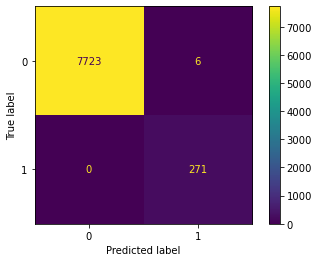

In [14]:
cm_train = confusion_matrix(y_train, y_train_pred_cv)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                              display_labels=rf_clf_cv.classes_)
disp.plot()

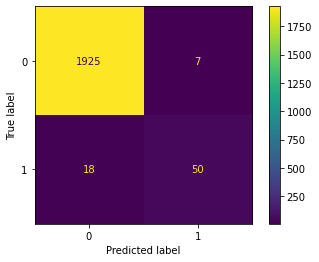

In [15]:
cm_test = confusion_matrix(y_test, y_test_pred_cv)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test,
                              display_labels=rf_clf_cv.classes_)
disp.plot()

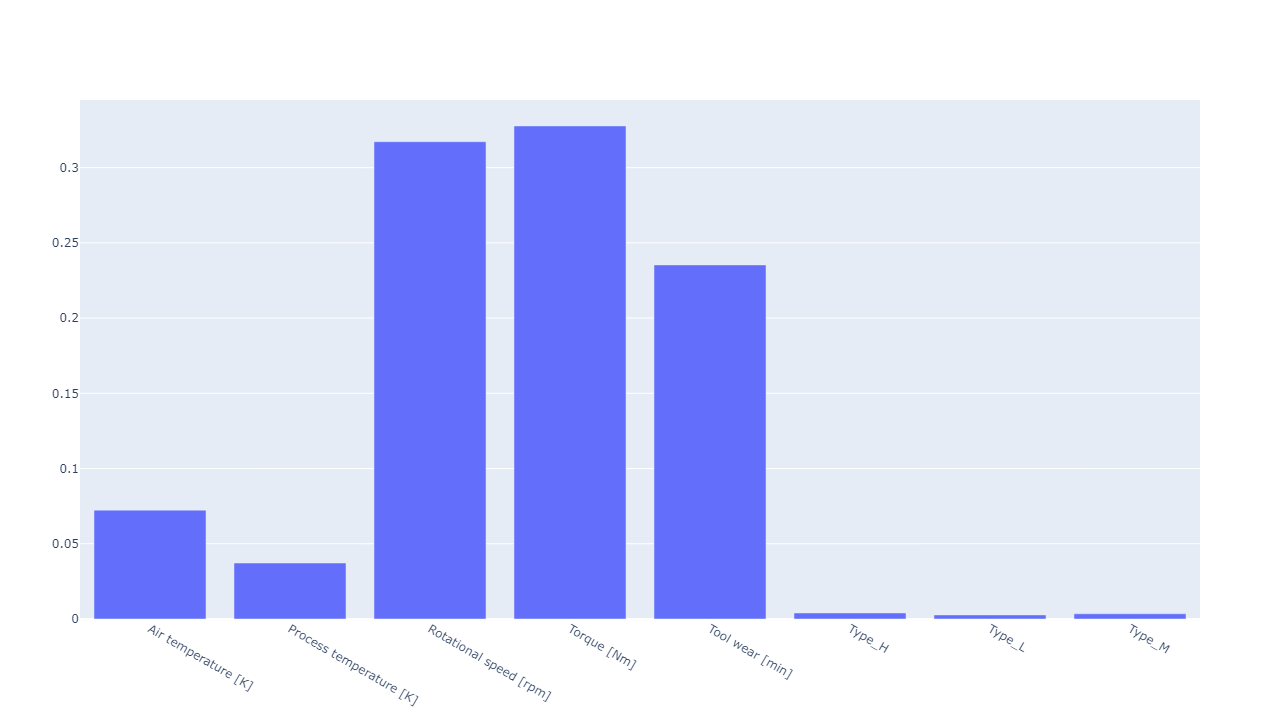

In [19]:
feature_importance_cv = pd.DataFrame({"name": X_train.columns, "importance": rf_clf_cv.best_estimator_.feature_importances_})
fig = go.Figure()
# fig.add_trace(go.Bar(x=feature_importance["name"], y=feature_importance["importance"], name="Simple Tree"))
fig.add_trace(go.Bar(x=feature_importance_cv["name"], y=feature_importance_cv["importance"], name="CV complex Tree"))
plot_figure(fig)